# Projetinho de DS
Esse notebook é referente ao projetinho de ingresso na área de Data Science do Grupo Turing. <br>
Ele está dividido em:
    - Web Scrapping
    - Análise e Limpeza de dados
        - Limpeza de dados
        - Análise Univariada
            - Avaliando os Gols Tomados e Feitos
            - Avaliando Torcedores
            - Avaliando Jogos fora e em Casa
            - Avaliando Save Percentage
            - Avaliando Penalty Minutes
            - Avaliando vitórias e derrotas
        - Análise Multivariada
            - Ánalise Fatorial exploratória
            - Ánalise de cluster exploratória
<br>
As analises multivariadas não foram bem sucedidas. Mas deixei mesmo assim, para mostrar o processo.

# Web Scrapping

Como primeira etapa, foi feita a extração dos dados dos dados so site https://scrapethissite.com/pages/forms/?.
Entrando no site é possível perceber que ele dispõe de paginação, mais precisamente, são 24 páginas contendo os dados em questão. 
Dessa forma, foram feitos multiplas requisições alterando na query do endereço a página desejada.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
URL = 'https://scrapethissite.com/pages/forms/?'

In [3]:
def get_raw_site(URL):
  """
  Retorna um objeto 'soup' de uma página web

  Keyword arguments:
    - URL: string contendo a url do site

  Outputs:
    - soup: objeto soup referente à página web
  """
  raw_site = requests.get(URL)
  status = raw_site.status_code
  assert  status == 200, f"Não foi possível estabelecer o site: status {status}"
  soup = BeautifulSoup(raw_site.text, 'html.parser')
  return soup

In [4]:
def soup_to_df(soup):
  """
  Extrai a tabela do objeto soup, transformando-a em um Data Frame do pandas

  Keyword arguments:
    - soup: objeto soup referente à página web

  Outputs:
    - df: Data Frame contendo a tabela extraída do objeto soup
  """
  table = soup.find('table')
  titles = table.find_all('th')
  titles = [title.text.strip() for title in titles]
  table_rows = table.find_all('tr')
  lines = []
  for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td] 
    if not(all(t == None for t in row)): 
      lines.append(row)
  df = pd.DataFrame(lines, columns=titles)
  return df

Utilizando as funções acima, foi extraído o data frame que contem os dados de interesse.

In [5]:
hockey_df = pd.DataFrame()
for i in range(1,25):
  url = f"{URL}page_num={i}"
  raw_site = get_raw_site(url)
  interm = soup_to_df(raw_site)
  hockey_df = hockey_df.append(interm)

# Análise e Visualização de Dados

## Data Cleaning

Os dados extraídos na etapa anterior


In [6]:
hockey_df.to_csv("hockey.csv")
hockey_df.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,,0.55,299,264,35
1,Buffalo Sabres,1990,31,30,,0.388,292,278,14
2,Calgary Flames,1990,46,26,,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,,0.425,273,298,-25


In [7]:
hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 6
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Team Name           582 non-null    object
 1   Year                582 non-null    object
 2   Wins                582 non-null    object
 3   Losses              582 non-null    object
 4   OT Losses           582 non-null    object
 5   Win %               582 non-null    object
 6   Goals For (GF)      582 non-null    object
 7   Goals Against (GA)  582 non-null    object
 8   + / -               582 non-null    object
dtypes: object(9)
memory usage: 45.5+ KB


Como pode ser visto, os dtypes estão incorretos. Arrumando isso:

In [8]:
hockey_df = hockey_df.astype({"Year": int, "Wins": int, "Losses": int, "Win %": float, "Goals For (GF)": int, "Goals Against (GA)": int, "+ / -": int})

In [9]:
hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 6
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Team Name           582 non-null    object 
 1   Year                582 non-null    int64  
 2   Wins                582 non-null    int64  
 3   Losses              582 non-null    int64  
 4   OT Losses           582 non-null    object 
 5   Win %               582 non-null    float64
 6   Goals For (GF)      582 non-null    int64  
 7   Goals Against (GA)  582 non-null    int64  
 8   + / -               582 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 45.5+ KB


Pronto, agora está certo

Importando os dados fornecidos

In [10]:
espn = pd.read_csv(r"DataSet ESPN.csv")

In [11]:
espn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               290 non-null    int64  
 1   Team                     290 non-null    object 
 2   Home Games               290 non-null    int64  
 3   Home Total               290 non-null    object 
 4   Home Average             290 non-null    object 
 5   Road Games               290 non-null    int64  
 6   Road Average             290 non-null    object 
 7   Overall Games            290 non-null    int64  
 8   Overall Average          290 non-null    object 
 9   Year                     290 non-null    int64  
 10  Save Percentage          290 non-null    float64
 11  Penalty Minutes          290 non-null    int64  
 12  Penalty Minutes Against  290 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 29.6+ KB


In [12]:
espn.head()

,Unnamed: 0,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,0,Montreal Canadiens,41,"824,308","20,105",41,"16,013",82,"18,059",2001,0.899,1020,1294
1,1,Detroit Red Wings,41,"819,795","19,995",41,"17,889",82,"18,942",2001,0.909,1082,1072
2,2,Philadelphia Flyers,41,"802,595","19,575",41,"17,182",82,"18,378",2001,0.903,1183,1332
3,3,St Louis Blues,41,"800,319","19,519",41,"16,898",82,"18,209",2001,0.899,1345,1366
4,4,Toronto Maple Leafs,41,"789,567","19,257",41,"17,172",82,"18,215",2001,0.908,1430,1243


Alguns valores numericos estão com o separador de milhar como vírgula. Vamos arrumar isso:

In [13]:
def arrumar_sep_milhar(series, column_prob):
    if series.name in column_prob:
        if series.dtype == 'object':
            series = series.replace(regex={r',': ''})
            series = pd.to_numeric(series, errors='coerce')
    return series

In [14]:
column_prob= ['Home Total', 'Home Average', 'Road Average', 'Overall Average']
espn = espn.apply(lambda x: arrumar_sep_milhar(x, column_prob))

Como pode ser visto, as colunas "chaves", ou seja, aquelas que servem de referência para o merge entre o dataset fornecido e o extraído são 'Year' e 'Team'.
Fazendo esse merge, temos:

In [15]:
espn['id'] = espn.apply(lambda x: str(x['Team']) + str(x['Year']), axis = 1)
hockey_df['id'] = hockey_df.apply(lambda x: str(x['Team Name']) + str(x['Year']), axis = 1)

In [16]:
hockey_completo = hockey_df.set_index('id').combine_first(espn.set_index('id')).reset_index()

In [17]:
hockey_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       635 non-null    object 
 1   + / -                    582 non-null    float64
 2   Goals Against (GA)       582 non-null    float64
 3   Goals For (GF)           582 non-null    float64
 4   Home Average             290 non-null    float64
 5   Home Games               290 non-null    float64
 6   Home Total               290 non-null    float64
 7   Losses                   582 non-null    float64
 8   OT Losses                582 non-null    object 
 9   Overall Average          290 non-null    float64
 10  Overall Games            290 non-null    float64
 11  Penalty Minutes          290 non-null    float64
 12  Penalty Minutes Against  290 non-null    float64
 13  Road Average             290 non-null    float64
 14  Road Games               2

## Análise Univariada

Agora que o dataset está completo, podemos começar a análise, vamos importar outras bibliotecas necessárias:

In [18]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Vamos começar com uma função ṕara simplificar as nossas análises univariadas. <br>
Uma coisa que pode ser verificada já de início é que as nossas features não são linearmente independentes, isso é claro, pois porcentagem de vitória pode ser obtida com derrotas, jogos fora de casa e jogos em casa, por exemplo.

In [19]:
def univariada(series):
  """
  Calcula medidas descritivas e mostra a distribuição dos dados

  Keyword arguments:
    - series: coluna de um Dataframe
  """ 
  if np.issubdtype(series.dtype, np.number):
    series_df = series
    series = np.array(series.dropna())
    nobs, minmax, media, variancia_amostral, assimetria_enviesada, curtose_enviesada   = stats.describe(series)
    curtose_amostral = stats.kurtosis(series, bias=False)
    assimetria_amostral = stats.skew(series, bias=False)
    normalizado = (series - media)/(variancia_amostral**0.5)
    _, pvalue_normal = stats.kstest(normalizado, 'norm')
    p25, p50, p75, p90 = np.percentile(series, 25), np.percentile(series, 50), np.percentile(series, 75), np.percentile(series, 90)
    print("Resumo:")
    print(f"Número de observações não nulas: {nobs} | Média: {media} | Desvio Padrão: {variancia_amostral**0.5} | Assimetria: {assimetria_amostral} | Curtose: {curtose_amostral}")
    print(f"Mínimo: {minmax[0]} | Primeiro Quartil: {p25} | Mediana: {p50} | Terceiro Quartil: {p75} | Percentil 90: {p90} | Máximo: {minmax[1]}")
    if pvalue_normal < 0.05:
     print("H0 rejeitado: há evidência de que a distribuição não é normal")
    else:
      print("H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal")
    print(f"P-valor do teste de Kolmogorov–Smirnov: {pvalue_normal}")
    ax = sns.distplot(series_df)
    ax.set_title(f"Distribuição: {series_df.name}")
  else:
    nobs = series.count()
    min = series.min()
    max = series.max()
    plt.hist(series)
    plt.title(f"Histograma: {series.name}")

#### Avaliando os Gols Tomados e Feitos

Resumo:
Número de observações não nulas: 582 | Média: 234.06357388316152 | Desvio Padrão: 42.510718457384776 | Assimetria: 0.3213196867747559 | Curtose: 1.2641218652425978
Mínimo: 115.0 | Primeiro Quartil: 207.0 | Mediana: 232.5 | Terceiro Quartil: 258.75 | Percentil 90: 286.0 | Máximo: 414.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.2459707921370612


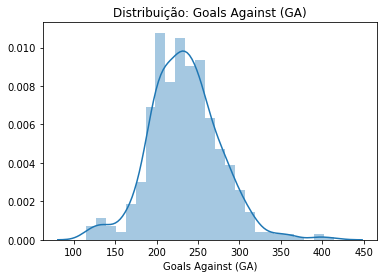

In [20]:
univariada(hockey_completo['Goals Against (GA)'])

Resumo:
Número de observações não nulas: 582 | Média: 234.06357388316152 | Desvio Padrão: 40.548915399123885 | Assimetria: 0.2488055599817491 | Curtose: 1.153962538877371
Mínimo: 115.0 | Primeiro Quartil: 211.0 | Mediana: 231.0 | Terceiro Quartil: 254.0 | Percentil 90: 282.9 | Máximo: 369.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 0.006779616709723314


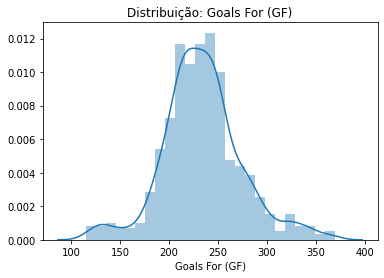

In [21]:
univariada(hockey_completo['Goals For (GF)'])

Como esperado, as médias dos gols feitos e dos gols tomados são iguais: todo o gol marcado por um time foi tomado por outro + o denominador é o mesmo (no de observações). <br> 
As outras métricas não são iguais. Em especial se verifica que:
  - O que mais parece saltar aos olhos é que a distribuição de gols feitos não parece ser normal (com p-valor < 1% 😮)
  - A distribuição dos gols feitos (GF) tem "cauda longa" quando comparada com os gols tomados (GA). "Cauda longa" é algo que se mostra comum em distribuições com desigualdades mais importantes. **Isso parece indicar que poucos times/temporada concentram a muitos dos gols**. (Exemplificando isso: distribuição de altura (normal) vs distribuição de livros vendidos por autor (cauda longa) (poucos autores concentram a maior parte das vendas de livros)). 
  - As duas distribuições são assimétricas para a esquerda (mediana menor que a média). Uma coisa interessante de se perceber é que a distribuição de gols feitos (GF) é menos assimétrica do que a de gols tomados (GA) (0.24 vs 0.32). Isso poderia ser explicado pelo fato de GF ter uma "cauda gorda" na direita (que ajuda a compensar a assimetria) - efeito direto da "desigualdade" comentada antes.  
<br>
Vamos fazer uma análise apenas por time ao invés de time/temporada e ver o que conseguimos descobrir...

In [22]:
times = hockey_completo.drop(columns=['Team Name'])
times = times.groupby(['Team']).mean()

Resumo:
Número de observações não nulas: 27 | Média: 225.2469135802469 | Desvio Padrão: 14.887560003629375 | Assimetria: -0.2793821227773841 | Curtose: -0.572176741146083
Mínimo: 192.55555555555554 | Primeiro Quartil: 215.8888888888889 | Mediana: 224.22222222222223 | Terceiro Quartil: 237.05555555555554 | Percentil 90: 245.24444444444447 | Máximo: 248.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.9541145465044429


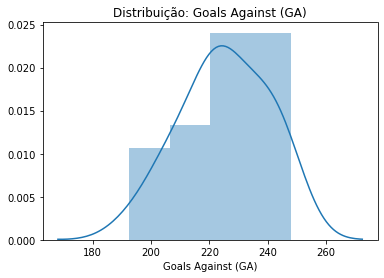

In [23]:
univariada(times['Goals Against (GA)'])

Resumo:
Número de observações não nulas: 27 | Média: 226.2551440329218 | Desvio Padrão: 15.248303030606866 | Assimetria: -0.4045125888556215 | Curtose: 0.5456686893548581
Mínimo: 187.33333333333334 | Primeiro Quartil: 217.33333333333331 | Mediana: 225.22222222222223 | Terceiro Quartil: 237.55555555555554 | Percentil 90: 241.7111111111111 | Máximo: 257.6666666666667
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.9466410829147622


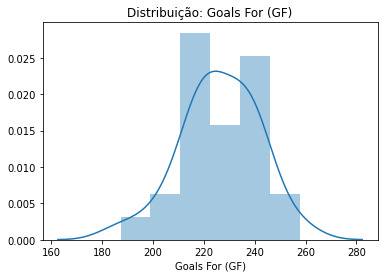

In [24]:
univariada(times['Goals For (GF)'])

Interessante.... <br>
Quando agrupamos por time, ambas assimetrias ficam negativas (mediana maior que média). GF perde a falta de normalidade. Isso me sugere que talvez a interação entre time e temporada possa ter uma influência. Intuitivamente, isso poderia fazer sentido... Pensando num exemplo mais próximo, no futebol um certo time pode estar "bem" em um ano e "mal" no outro <br>
Infelizmente 😪 temos muitas combinações de anos e times, o que faz com que esse dataset em específico não possua observações o suficiente para montar um design fatorial. Não podemos calcular o efeito de interação entre Ano e Time com um anova (apenas os efeitos principais). Mas podemos ter alguma ideia com pointplots.

In [25]:
def one_way_anova(values, groups):
    classes = groups.unique()
    #print(f"Avaliando diferenças de {values.name} entre {', '.join(classes)}")
    g = []
    for c in classes:
        cl = values[groups == c]
        g.append(cl)
    return stats.f_oneway(*g)

In [26]:
df = hockey_completo[['Goals For (GF)','Goals Against (GA)', 'Year', 'Team']].dropna()
df = df.astype({'Year': 'category', 'Team': 'category'})
one_way_anova(df['Goals Against (GA)'], df['Team'])

F_onewayResult(statistic=2.9905577033589235, pvalue=7.115358396656379e-06)

In [27]:
anova_df = hockey_completo[['Goals For (GF)', 'Goals Against (GA)', 'Year', 'Team']]
anova_df = anova_df.astype({'Year': 'category', 'Team': 'category'})
anova_df = anova_df.rename({'Goals For (GF)': 'GF', 'Goals Against (GA)': 'GA'}, axis='columns')
anova_df = anova_df.dropna()
anova_df.columns

Index(['GF', 'GA', 'Year', 'Team'], dtype='object')

**Para o GA** <br>
Usando 1-way ANOVA (paramétrico)

In [28]:
one_way_anova(anova_df['GA'], anova_df['Year'])

F_onewayResult(statistic=5.19219327605574, pvalue=5.703039286144411e-06)

In [29]:
one_way_anova(anova_df['GA'], anova_df['Team'])

F_onewayResult(statistic=2.9905577033589235, pvalue=7.115358396656379e-06)

No caso de gols tomados, obtemos p-valores baixos, o que quer dizer que existe diferenciação da média de gols tomados tanto por ano quanto por time.
<br>
Podemos observar isso de forma mais explícita nos gráficos abaixo.

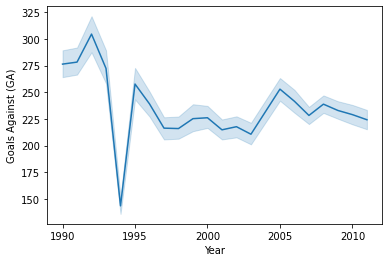

In [30]:
ax = sns.lineplot(x =hockey_completo["Year"],y=hockey_completo["Goals Against (GA)"])

Os anos fazem diferença e....

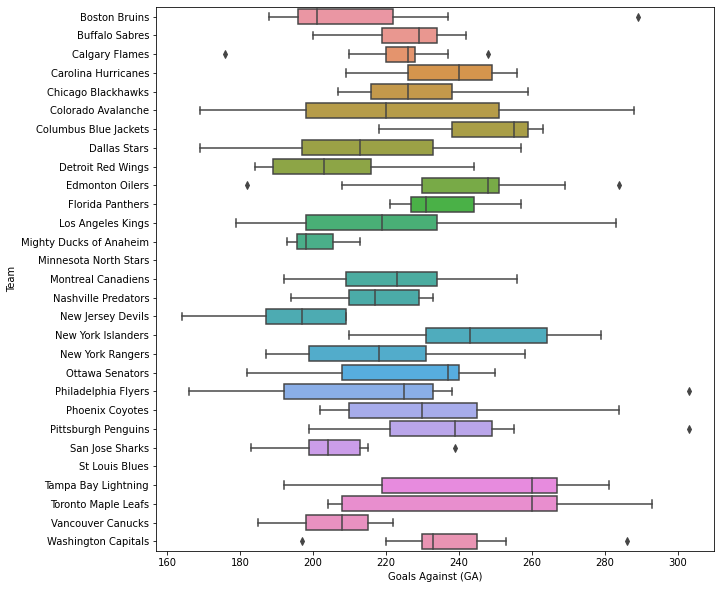

In [31]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=hockey_completo,
    x='Goals Against (GA)',
    y='Team')

... alguns times claramente são piores do que outros, levando mais gols.

Para não ficara muito poluido vamos tentar um pointplot com poucos anos. Assim podemos ver a interação entre temporada e time.

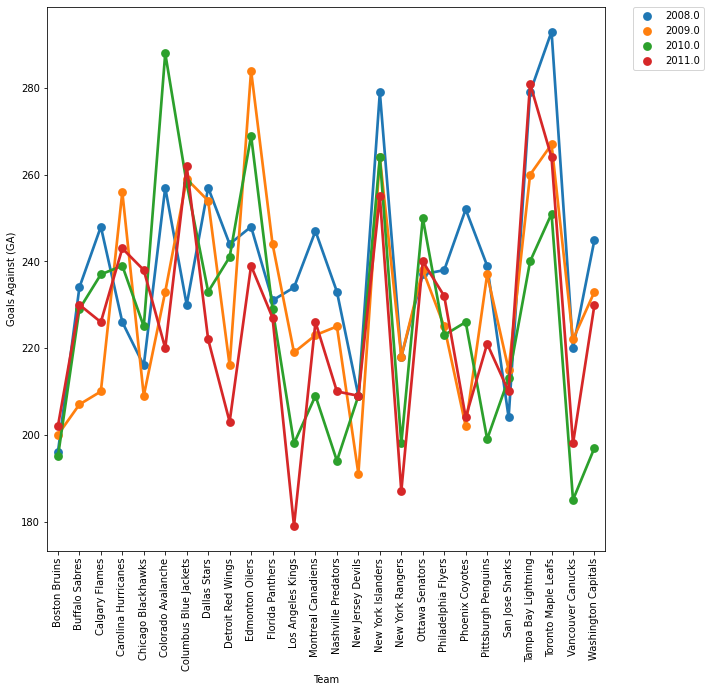

In [32]:
point_df = hockey_completo[hockey_completo['Year'] > 2007].dropna()
plt.figure(figsize=(10,10))
g = sns.pointplot(y=point_df['Goals Against (GA)'], x=point_df['Team'], hue = point_df['Year'])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Como as linhas, em vários trechos, não são paralelas, temos indicios de efeito de interação

**Para o GF** <br>
Usando Kruskal-Wally (não paramétrico)

In [33]:
def faz_kruskal(target, fator):
  niveis = fator.unique()
  dfs = []
  for nivel in niveis:
    df = fator[fator == nivel]
    dfs.append(df)
  return stats.kruskal(*dfs)

In [34]:
faz_kruskal(anova_df['GF'], anova_df['Year'])

KruskalResult(statistic=235.9999999999999, pvalue=1.591597615546794e-46)

In [35]:
faz_kruskal(anova_df['GF'], anova_df['Team'])

KruskalResult(statistic=235.9999999999999, pvalue=9.585620757974422e-36)

Novamente, ambos fatores se mostraram ter diferenças quanto ao numero de gols, nesse caso marcados.


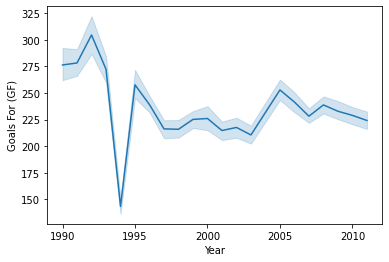

In [36]:
ax = sns.lineplot(x =hockey_completo["Year"],y=hockey_completo["Goals For (GF)"])

Como esperado, o lineplot é igual ao gols marcados contra

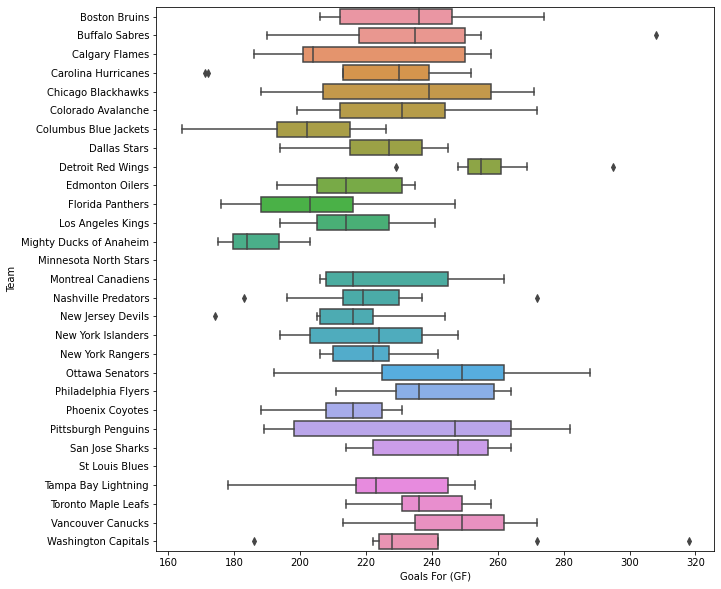

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=hockey_completo,
    x='Goals For (GF)',
    y='Team')

Novamente, vendo os efeitos de interação, percebemos que, na maioria dos trechos, as linhas não são paralelas.

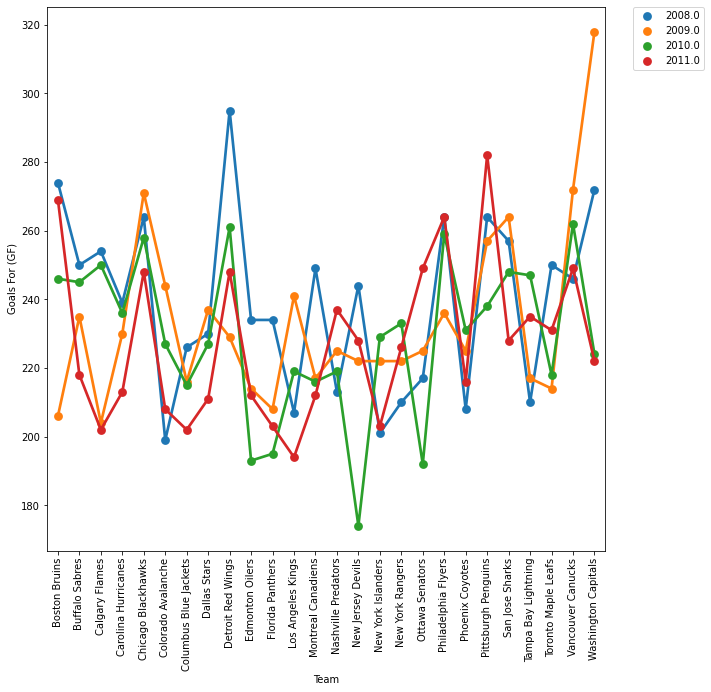

In [38]:
point_df = hockey_completo[hockey_completo['Year'] > 2007].dropna()
plt.figure(figsize=(10,10))
g = sns.pointplot(y=point_df['Goals For (GF)'], x=point_df['Team'], hue = point_df['Year'])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Avaliando Torcedores

Resumo:
Número de observações não nulas: 290 | Média: 17012.513793103448 | Desvio Padrão: 2177.9020987436984 | Assimetria: -0.2587739328822026 | Curtose: -0.3845212921154193
Mínimo: 11059.0 | Primeiro Quartil: 15433.0 | Mediana: 17210.5 | Terceiro Quartil: 18566.0 | Percentil 90: 19557.3 | Máximo: 22247.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.15659881566544465


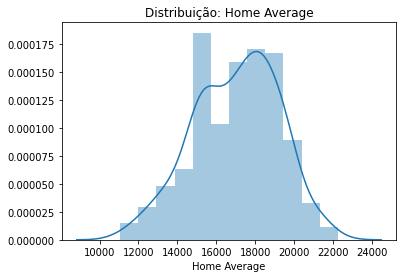

In [39]:
univariada(hockey_completo['Home Average'])

Resumo:
Número de observações não nulas: 290 | Média: 696862.8275862068 | Desvio Padrão: 89095.44144928423 | Assimetria: -0.26653271904829196 | Curtose: -0.36577301532088935
Mínimo: 453456.0 | Primeiro Quartil: 632779.75 | Mediana: 703766.0 | Terceiro Quartil: 760915.0 | Percentil 90: 801851.0 | Máximo: 912155.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.20960501524184094


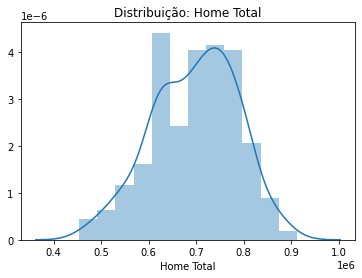

In [40]:
univariada(hockey_completo['Home Total'])

Resumo:
Número de observações não nulas: 290 | Média: 16948.35172413793 | Desvio Padrão: 589.707739836118 | Assimetria: 0.1729538938777196 | Curtose: 0.11778464126782051
Mínimo: 15575.0 | Primeiro Quartil: 16567.5 | Mediana: 16956.5 | Terceiro Quartil: 17317.0 | Percentil 90: 17707.800000000003 | Máximo: 19002.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.8844219795427916


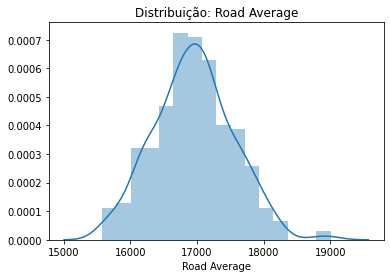

In [41]:
univariada(hockey_completo['Road Average'])

Resumo:
Número de observações não nulas: 290 | Média: 16980.43793103448 | Desvio Padrão: 1191.5516495328077 | Assimetria: -0.12323875460076678 | Curtose: -0.44819533631766717
Mínimo: 14026.0 | Primeiro Quartil: 16096.0 | Mediana: 17018.5 | Terceiro Quartil: 17878.25 | Percentil 90: 18364.5 | Máximo: 19896.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.4127604429058387


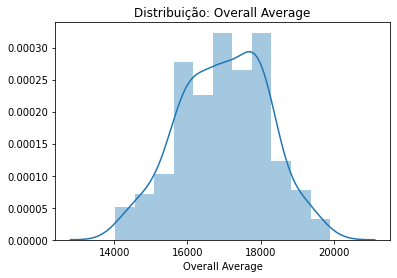

In [42]:
univariada(hockey_completo['Overall Average'])

Todas as distribuições acima parecem ter aderencia à distribuição normal. 
Como esperado, as distribuições de Home Total e Home average tem formato muito parecido (o que pode ser verificado nos valores de curtose e assimetria). Isso é esperado, uma vez que esses dados são dependentes (o Home Average é o Home Total dividido pelo número de jogos em casa). <br>
Vemos que os jogos em casa **parecem** ter um número maior de espctadores. Vamos verificar isso

In [43]:
casa = np.array(hockey_completo['Home Average'].dropna())
estrada = hockey_completo['Road Average'].dropna()

In [44]:
stats.levene(casa,estrada)

LeveneResult(statistic=299.24910038905506, pvalue=2.4407143525656302e-54)

Verificamos que as variancias são diferentes, vamos agora fazer o teste T.

In [45]:
stats.ttest_ind(casa, estrada, equal_var=False)

Ttest_indResult(statistic=0.4842562844263766, pvalue=0.6285241076230295)

Apesar de parecer que as médias eram diferentes em casa e na estrada. Não podemos afirmar isso com significancia estatística, já que nosso p-valor foi de 62%.

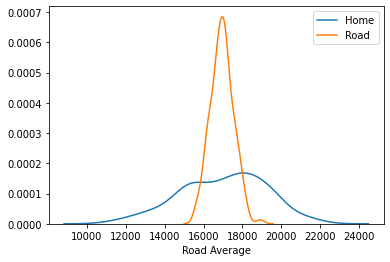

In [46]:
sns.distplot(casa, hist=False, label="Home")
sns.distplot(estrada, hist=False, label = "Road")
plt.legend()

Sobrepondo as duas distribuições dá pra ver que (realmente) a variância delas é diferente. Quanto a média, é mais dificil fazer uma afirmação (bem como disse o teste T)

### Avaliando Jogos fora e em Casa

Resumo:
Número de observações não nulas: 290 | Média: 40.96206896551724 | Desvio Padrão: 0.22463163710824355 | Assimetria: -2.8663709151745707 | Curtose: 15.642671332205865
Mínimo: 40.0 | Primeiro Quartil: 41.0 | Mediana: 41.0 | Terceiro Quartil: 41.0 | Percentil 90: 41.0 | Máximo: 42.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 3.8715777164680626e-74


/home/luisa/.local/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


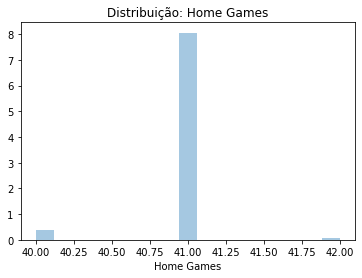

In [47]:
univariada(hockey_completo['Home Games'])

/home/luisa/.local/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Resumo:
Número de observações não nulas: 290 | Média: 40.96206896551724 | Desvio Padrão: 0.22463163710824352 | Assimetria: -2.8663709151745707 | Curtose: 15.642671332205865
Mínimo: 40.0 | Primeiro Quartil: 41.0 | Mediana: 41.0 | Terceiro Quartil: 41.0 | Percentil 90: 41.0 | Máximo: 42.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 3.8715777164680626e-74


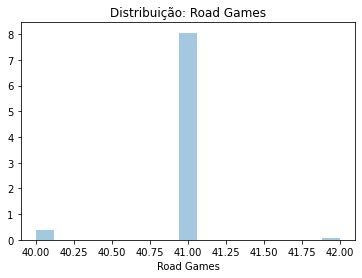

In [48]:
univariada(hockey_completo['Road Games'])

Aqui não tem muito o que dizer... Quase sempre a quantidade de jogos disputados dentro e fora de casa é a mesma. Esse número é quase sempre 41!

### Avaliando Save Percentage

Resumo:
Número de observações não nulas: 290 | Média: 0.9055275862068966 | Desvio Padrão: 0.009383833427420841 | Assimetria: -0.11834459028185605 | Curtose: -0.41300065432947086
Mínimo: 0.884 | Primeiro Quartil: 0.89925 | Mediana: 0.9059999999999999 | Terceiro Quartil: 0.9129999999999999 | Percentil 90: 0.9179999999999999 | Máximo: 0.93
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.34068194205749414


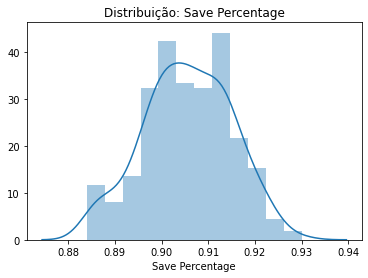

In [49]:
univariada(hockey_completo['Save Percentage'])

Bom, parece que a maioria das finalizações acabam defendidas. (Em média, aproximadamente 90%). 
<br> Podemos verificar se existe diferença na *save percentage* pelo time.

In [50]:
anova_df2 = hockey_completo[['Save Percentage', 'Team']]
anova_df2 = anova_df2.astype({'Team': 'category'})
anova_df2 = anova_df2.rename({'Save Percentage': 'SP'}, axis='columns')
anova_df2 = anova_df2.dropna()
one_way_anova(anova_df2['SP'], anova_df2['Team'])

F_onewayResult(statistic=3.1624185505206586, pvalue=6.875213672197019e-07)

Parece que a resposta é sim. Existe diferença nas médias da porcentagem de defesas entre os times

### Avaliando Penalty Minutes

Resumo:
Número de observações não nulas: 290 | Média: 1169.4448275862069 | Desvio Padrão: 194.63534902684205 | Assimetria: 0.2990641618323482 | Curtose: 0.6207663189721817
Mínimo: 710.0 | Primeiro Quartil: 1038.25 | Mediana: 1170.5 | Terceiro Quartil: 1286.5 | Percentil 90: 1433.1000000000001 | Máximo: 1994.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.815171588721658


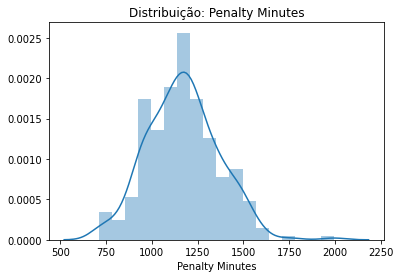

In [51]:
univariada(hockey_completo['Penalty Minutes'])

Resumo:
Número de observações não nulas: 290 | Média: 1170.2137931034483 | Desvio Padrão: 173.5433966929759 | Assimetria: 0.24528757046603486 | Curtose: 0.4221427304543939
Mínimo: 696.0 | Primeiro Quartil: 1055.5 | Mediana: 1165.0 | Terceiro Quartil: 1283.0 | Percentil 90: 1384.3000000000002 | Máximo: 1818.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.9755463758516066


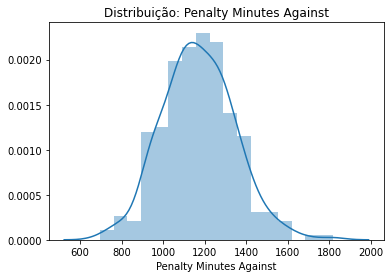

In [52]:
univariada(hockey_completo['Penalty Minutes Against'])

Tanto o número de minutos em penalidade do time quanto dos times contra tem assimetria postiiva (mediana menor que média), ambas assimetrias são baixas, entretanto.
As duas distribuições parecem ter bastante aderência à distribuição normal, o que pode ser visto pelos extremamente elevados p-valor.

In [53]:
anova_df3 = hockey_completo[['Penalty Minutes Against', 'Penalty Minutes', 'Year', 'Team']]
anova_df3 = anova_df3.astype({'Year': 'category', 'Team': 'category'})
anova_df3 = anova_df3.rename({'Penalty Minutes Against': 'PMA', 'Penalty Minutes': 'PM'}, axis='columns')
anova_df3 = anova_df3.dropna()

In [54]:
one_way_anova(anova_df3['PMA'], anova_df3['Year'])

F_onewayResult(statistic=10.409004366778436, pvalue=7.107445644565637e-14)

In [55]:
one_way_anova(anova_df3['PMA'], anova_df3['Team'])

F_onewayResult(statistic=2.471972685441894, pvalue=0.00010962584833657735)

Como podemos ver, tanto os Penalty Minutes Against quanto Penalty Minutes tem diferença de média entre times e temporadas. <br>
visualizando:

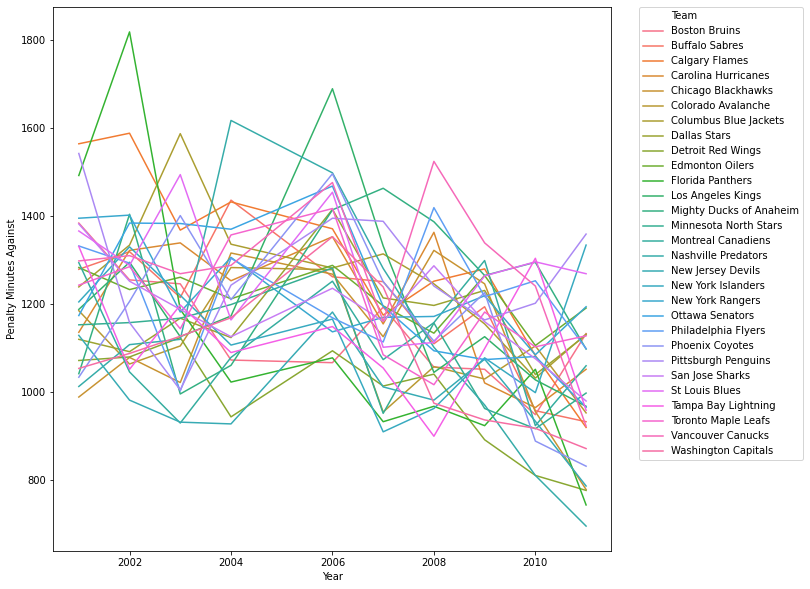

In [56]:
plt.figure(figsize=(10,10))
sns.lineplot(y = 'Penalty Minutes Against', x = 'Year', data = hockey_completo, hue = 'Team')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

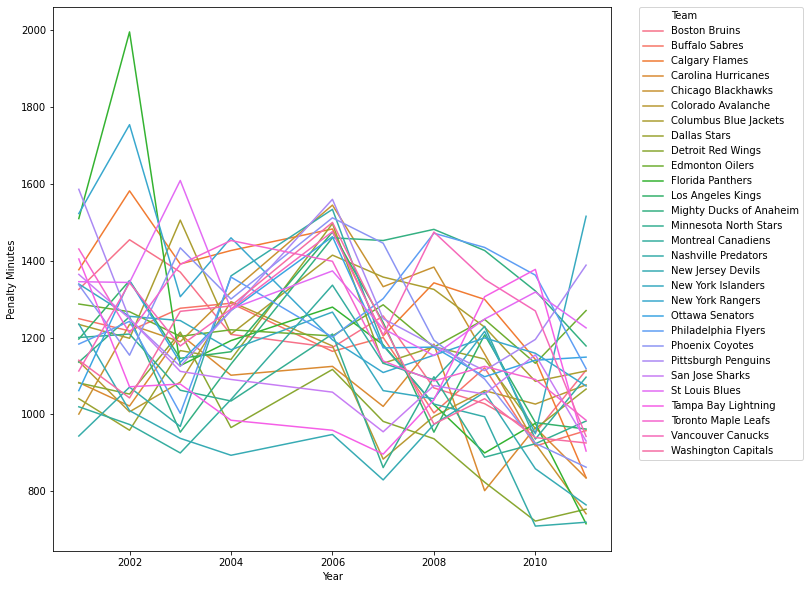

In [57]:
plt.figure(figsize=(10,10))
sns.lineplot(y = 'Penalty Minutes', x = 'Year', data = hockey_completo, hue = 'Team')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Analisando Derrotas e Vitórias

Resumo:
Número de observações não nulas: 582 | Média: 32.35395189003437 | Desvio Padrão: 8.41143860049322 | Assimetria: 0.6538725628418944 | Curtose: 1.2344168254459014
Mínimo: 11.0 | Primeiro Quartil: 27.0 | Mediana: 31.0 | Terceiro Quartil: 37.0 | Percentil 90: 43.0 | Máximo: 71.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 0.0031612882106136224


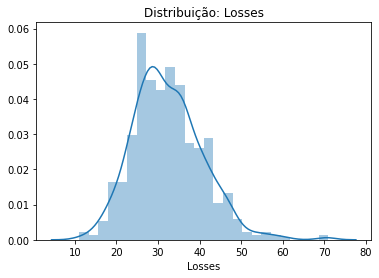

In [58]:
univariada(hockey_completo['Losses'])

Resumo:
Número de observações não nulas: 582 | Média: 36.94329896907217 | Desvio Padrão: 8.92608092028576 | Assimetria: -0.39376668455992136 | Curtose: -0.16011641592803683
Mínimo: 9.0 | Primeiro Quartil: 31.0 | Mediana: 38.0 | Terceiro Quartil: 43.0 | Percentil 90: 48.0 | Máximo: 62.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 0.010283840132751493


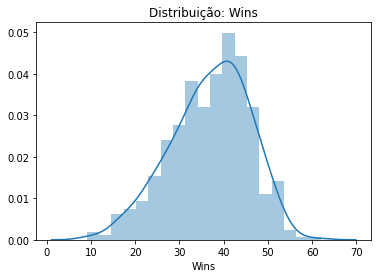

In [59]:
univariada(hockey_completo['Wins'])

Como pode ser visto, nenhuma das duas distribuições foi considerada normal. <br>
Isso era esperado, já que esportes tendem a ter vitórias desbalanceadas. A hipótese natural é de que alguns times são muito melhores do que outros e acumulam muitas vitórias. <br>
Vamos fazer um teste para checar isso:

In [60]:
def one_way_anova(values, groups):
    classes = groups.unique()
    g = []
    for c in classes:
        cl = values[groups == c]
        g.append(cl)
    return stats.f_oneway(*g)

In [61]:
anova_df4 = hockey_completo[['Wins', 'Losses', 'Year', 'Team']]
anova_df4 = anova_df4.astype({'Year': 'category', 'Team': 'category'})
anova_df4 = anova_df4.dropna()
one_way_anova(anova_df4['Wins'], anova_df4['Team'])

F_onewayResult(statistic=3.4877304953748784, pvalue=2.4929946034406784e-07)

In [62]:
one_way_anova(anova_df4['Losses'], anova_df4['Team'])

F_onewayResult(statistic=3.143996494644597, pvalue=2.540728464559141e-06)

De fato, como esperado, há diferença por times na média de vitórias

## Análise Multivariada

### Análise Fatorial Exploratória

Bom, como já dito antes, as features são dependentes. Isso pode ser percebido sem nenhum plot de correlação, é uma decorrencia de que algumas colunas são obtidas com combinações lineares de outras, por definição. <br>

Com isso dado, quero verificar se existe alguma dimensão intrínseca nesse dataset, e se posso conseguir isso com interpretabilidade. Talvez conseguir construtos mais abstratos. Então vou fazer uma análise fatorial exploratória....

In [63]:
from sklearn.decomposition import FactorAnalysis, PCA

In [64]:
hockey_factorial = hockey_completo[['+ / -', 'Goals Against (GA)', 'Goals For (GF)', 'Home Average',
       'Home Games', 'Home Total', 'Losses', 'Overall Average',
       'Overall Games', 'Penalty Minutes', 'Penalty Minutes Against',
       'Road Average', 'Road Games', 'Save Percentage', 'Win %', 'Year']]
hockey_factorial = hockey_factorial.dropna()

In [65]:
transformer = PCA(n_components=hockey_factorial.columns.shape[0], random_state=0)
componentes = transformer.fit(hockey_factorial.dropna())

In [66]:
eigenvalues = componentes.explained_variance_ratio_

Text(0.5, 1.0, 'Scree Plot')

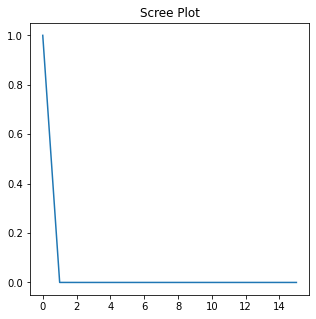

In [67]:
x = np.array(np.array(range(16)))
plt.figure(figsize=(5,5))
ax = sns.lineplot(y=eigenvalues, x = x)
ax.set_title("Scree Plot")

Infelizmente, não parece ter uma dimensão muito interpretável... Já que 99% da variância explicada das features estão contidas em uma única dimensão. Isso em si é bem curioso e nos leva a querer entender as correlações entre as features. <br>

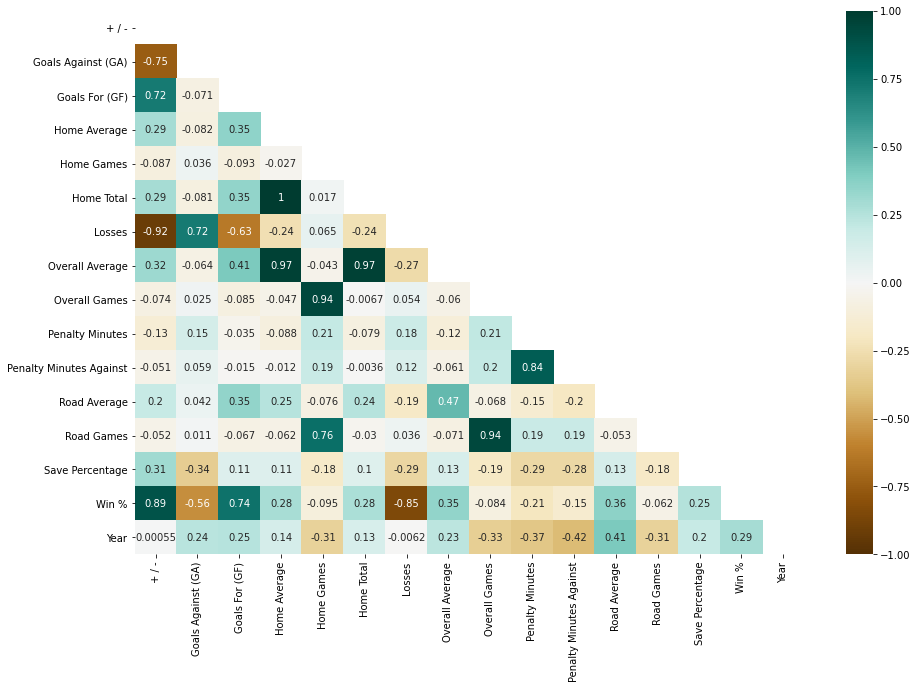

In [68]:
corr = hockey_factorial.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask,annot=True,vmin=-1, vmax=1, cmap='BrBG')

### Análise de cluster exploratória

Vamos testar agora clusterização. Promeiro vamos analizar o dendograma hierárquico para ver se há um número claro de clusters.

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [70]:
dims_numericas = [ '+ / -', 'Goals Against (GA)', 'Goals For (GF)', 'Home Average', 'Home Total', 
                  'Losses', 'Overall Average', 'Penalty Minutes', 'Penalty Minutes Against','Road Average', 'Save Percentage', 'Win %']
cluster_df = hockey_completo[dims_numericas].dropna()
scaled_features = StandardScaler().fit_transform(cluster_df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=cluster_df.index, columns=cluster_df.columns)

In [71]:
linked = linkage(scaled_features_df, 'single')

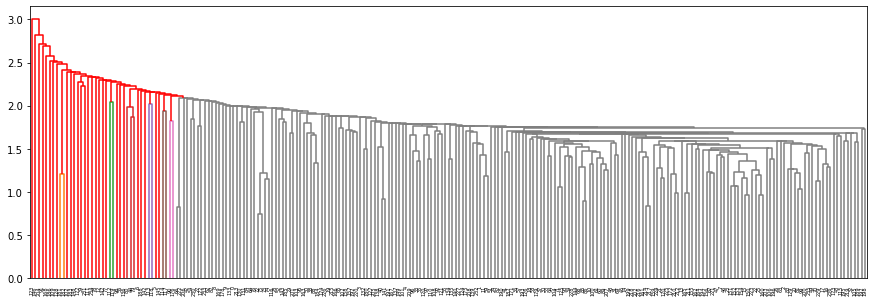

In [72]:
plt.figure(figsize=(15, 5))
dendrogram(linked,  above_threshold_color='r',orientation='top')
plt.show()

Não parce ter um número ok de clusters. Não creio que valha a pena seguir com análise de cluster.

# fim